In [1]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

train_input = input_variables[:80]
train_output = output_variable[:80]

test_input = input_variables[80:]
test_output = output_variable[80:]

     |████████████████████████████████| 10.0 MB 4.5 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 881647616 of 905208634 bytes (97.4%,    0.3s remaining) ...done. (10 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)



Dataset created in /root/nilearn_data/craddock_2012



 ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/craddock_2012/45a4e574a5c116b8be81d080bdaa0814/craddock_2011_parcellations.tar.gz..... done.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


10 regions found in this atlas


In [2]:
seeds = np.random.randint(100, size=20)
### K-means ####
kmeans = KMeans(n_clusters=10,random_state=1).fit(train_input) ### feature engineering on train_split
kmeans_input_variables= kmeans.transform(input_variables)
# kmeans_test_input = kmeans.transform(test_input)

### GMM ####
GMM = GaussianMixture(n_components=10,random_state=1).fit(train_input) ### feature engineering on train_split
gmm_input_variables = GMM.predict_proba(input_variables)
# GMM_test_input = GMM.predict_proba(test_input)

### PCA ####
pca = PCA(n_components=10,random_state=1).fit(train_input) ### feature engineering on train_split
pca_input_variables = pca.transform(input_variables)
# pca_test_input = pca.transform(test_input)

### ICA ####
ica = FastICA(n_components=10,random_state=1).fit(train_input) ### feature engineering on train_split
ica_input_variables = ica.transform(input_variables)
# ica_test_input = ica.transform(test_input)

km_y_list = [] 
gmm_y_list = [] 
pca_y_list = [] 
ica_y_list = [] 

for seed in seeds:
  kf = KFold(n_splits=5, random_state=seed, shuffle=True)
  for train_index, test_index in kf.split(output_variable):
    ######### KMeans #########
    kmeans_X_train, kmeans_X_test = kmeans_input_variables[train_index], kmeans_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    kmeans_Logmodel = SGDRegressor(penalty='l2', alpha=0.0001).fit(kmeans_X_train, y_train)
    km_y_list.append(kmeans_Logmodel.coef_) ############################################################# I'm not sure if this is what you mean by weights, so I just took the advice from Discussion Board ##########################################
    # kmeans_log_predict_output = kmeans_Logmodel.predict(kmeans_X_test)
    # km_accuracy += np.sum(kmeans_log_predict_output == y_test)/len(y_test)

    ######### GMM #########
    gmm_X_train, gmm_X_test = gmm_input_variables[train_index], gmm_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    gmm_Logmodel = SGDRegressor(penalty='l2', alpha=0.0001).fit(gmm_X_train, y_train) 
    gmm_y_list.append(gmm_Logmodel.coef_) ############################################################# I'm not sure if this is what you mean by weights, so I just took the advice from Discussion Board ##########################################
    # gmm_log_predict_output = gmm_Logmodel.predict(gmm_X_test)
    # gmm_accuracy += np.sum(gmm_log_predict_output == y_test)/len(y_test)

    ######### PCA #########
    pca_X_train, pca_X_test = pca_input_variables[train_index], pca_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    pca_Logmodel = SGDRegressor(penalty='l2', alpha=0.0001).fit(pca_X_train, y_train)
    pca_y_list.append(pca_Logmodel.coef_) ############################################################# I'm not sure if this is what you mean by weights, so I just took the advice from Discussion Board ##########################################
    # pca_log_predict_output = pca_Logmodel.predict(pca_X_test)
    # pca_accuracy += np.sum(pca_log_predict_output == y_test)/len(y_test)

    ######### ICA #########
    ica_X_train, ica_X_test = ica_input_variables[train_index], ica_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    ica_Logmodel = SGDRegressor(penalty='l2', alpha=0.0001).fit(ica_X_train, y_train)
    ica_y_list.append(ica_Logmodel.coef_) ############################################################# I'm not sure if this is what you mean by weights, so I just took the advice from Discussion Board ##########################################
    # ica_log_predict_output = ica_Logmodel.predict(ica_X_test)
    # ica_accuracy += np.sum(ica_log_predict_output == y_test)/len(y_test)

# km_y_list = np.array(km_y_list).squeeze().transpose()
# gmm_y_list = np.array(gmm_y_list).squeeze().transpose()
# pca_y_list = np.array(pca_y_list).squeeze().transpose()
# ica_y_list = np.array(ica_y_list).squeeze().transpose()

km_y_list = np.array(km_y_list).squeeze()
gmm_y_list = np.array(gmm_y_list).squeeze()
pca_y_list = np.array(pca_y_list).squeeze()
ica_y_list = np.array(ica_y_list).squeeze()

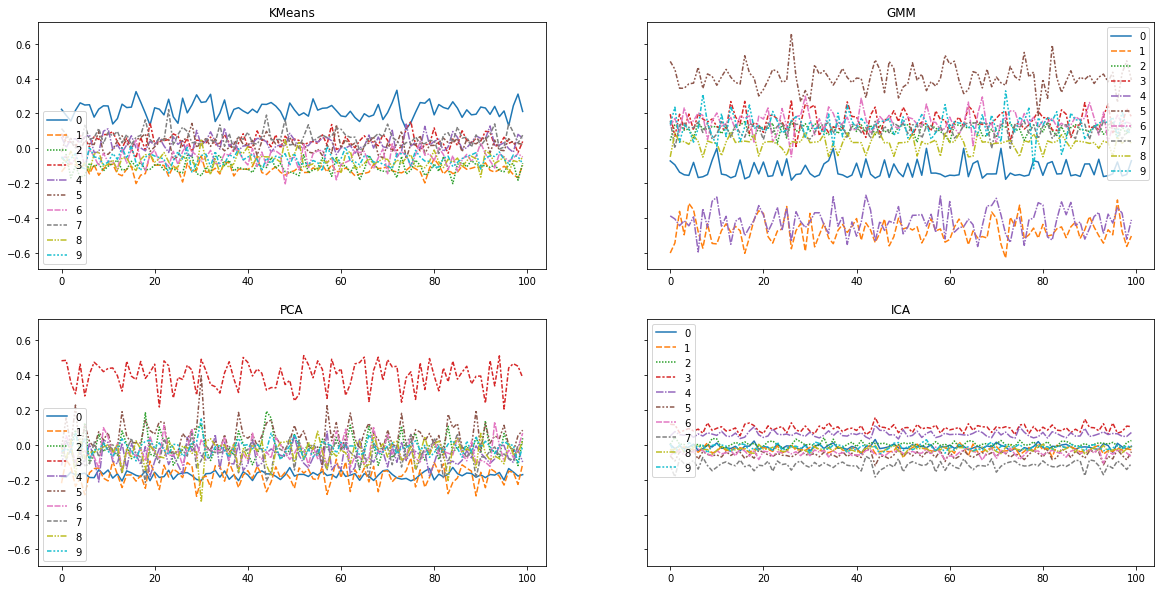

In [4]:
fig,axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

# ax_km_y_list = sns.scatterplot(data=km_y_list,ax=axes[0,0])
# ax_gmm_y_list = sns.scatterplot(data=gmm_y_list,ax=axes[0,1])
# ax_pca_y_list = sns.scatterplot(data=pca_y_list,ax=axes[1,0])
# ax_ica_y_list = sns.scatterplot(data=ica_y_list,ax=axes[1,1])
ax_km_y_list = sns.lineplot(data=km_y_list,ax=axes[0,0])
ax_gmm_y_list = sns.lineplot(data=gmm_y_list,ax=axes[0,1])
ax_pca_y_list = sns.lineplot(data=pca_y_list,ax=axes[1,0])
ax_ica_y_list = sns.lineplot(data=ica_y_list,ax=axes[1,1])

ax_km_y_list.set_title('KMeans')
ax_gmm_y_list.set_title('GMM')
ax_pca_y_list.set_title('PCA')
ax_ica_y_list.set_title('ICA')
# ax_km_y_list.legend_.remove()
# ax_gmm_y_list.legend_.remove()
# ax_pca_y_list.legend_.remove()
# ax_ica_y_list.legend_.remove()
# plt.xticks(x_list)
# # plt.plot(x_list,log_y_list,label='LogReg')
# # plt.plot(x_list,KNN_y_list,label='KNN')
# plt.plot(x_list,km_y_list,label='KMeans')
# plt.plot(x_list,gmm_y_list,label='GMM')
# plt.plot(x_list,pca_y_list,label='PCA')
# plt.plot(x_list,ica_y_list,label='ICA')
# plt.legend()
plt.show()